In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on cuda


In [4]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        return sequence

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [49]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):#, dropout_prob=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):#, dropout_prob=0.2):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        
        hidden = (hidden[0], hidden[1])
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(self, input_size, hidden_size, latent_size, seq_len, num_layers, device):#, dropout_prob):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            # dropout=self.dropout_prob
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            # dropout=self.dropout_prob
        )


        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        # x = x.unsqueeze(dim=1)
        # print('x shape: ', x.shape)
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)
    
    def encode(self, x):
        batch_size, seq_len, feature_dim = x.shape
        
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        
        return z
    
    def decode(self, z):
        batch_size, seq_len, feature_dim = z.shape
        
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        return x_hat
    
    def reconstruct(self, x):
        # print("reconstruct x shape: ", x.shape)
        batch_size, seq_len, feature_dim = x.shape
        

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        latent = z
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        # print("x hat shape: ", x_hat.shape)

        return latent, x_hat

    def loss_function(self, *args, **kwargs) -> dict:
        """
        
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

0        -3.948768
1        -3.963551
2        -3.872089
3        -3.867484
4        -3.892834
            ...   
161275   -3.747522
161276   -3.804183
161277   -3.730558
161278   -3.392240
161279   -3.416911
Length: 161280, dtype: float64

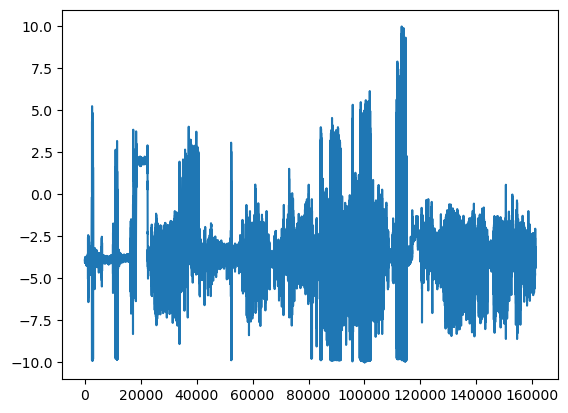

In [6]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info

dataset = dataset.to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-10, 10))

dataset = scaler.fit_transform(dataset)
dataset = pd.Series(dataset.squeeze())
plt.plot(dataset)
dataset

In [50]:
LOAD_MODEL = True
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

batch_size = 128
input_size = 1
hidden_size = 256
latent_size = 128
sequence_len = 128
num_layers = 2
clip_value = 10

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\aug-3'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', 
      model)

decoder layers:  2
model loaded from state dict | system:  Windows
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    print("datas shape: ", datas.shape)
    break

train_loss = []
test_loss = []
learning_rate = []

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000002884A105F90>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [9]:
def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )
        
        temp = -1
        
        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            temp = float(mloss.mean())
            
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"test_loss": float(mloss.mean())})
                temp = float(mloss.mean())
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [10]:
# torch.save(model.state_dict(), 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\aug_3_2_layers')

In [11]:
# iterations = 500000 # iterations = total iterations, epochs = iterations / len(dataloader)
# train(iterations, model, train_loader, test_loader)

In [12]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:

            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [13]:
reconstruction = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [14]:
print(len(reconstruction))
print(reconstruction[1000])

129024
tensor(-3.9878, device='cuda:0')


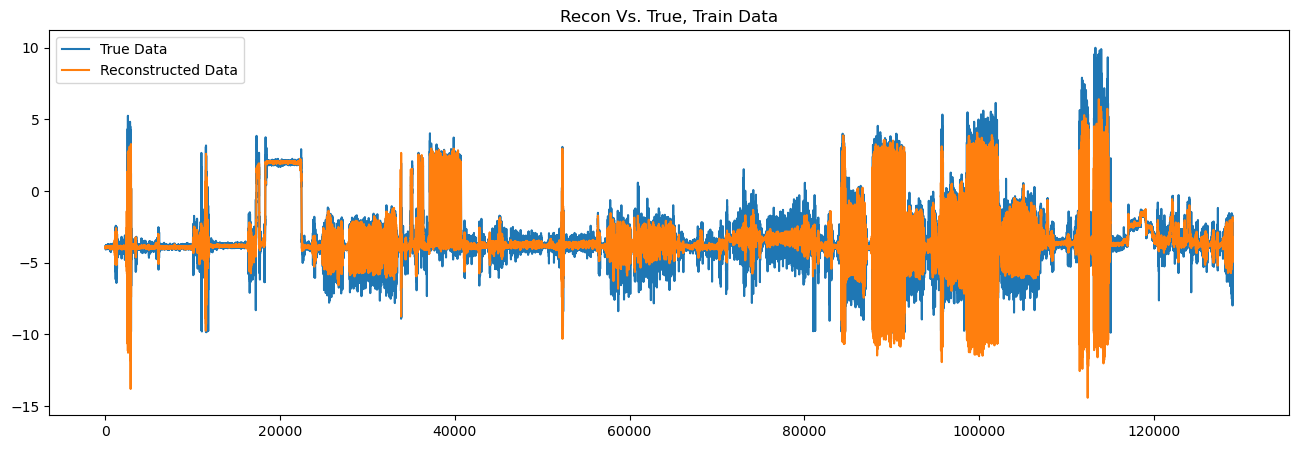

In [15]:
plt.figure(figsize=(16,5))
plt.title("Recon Vs. True, Train Data")
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

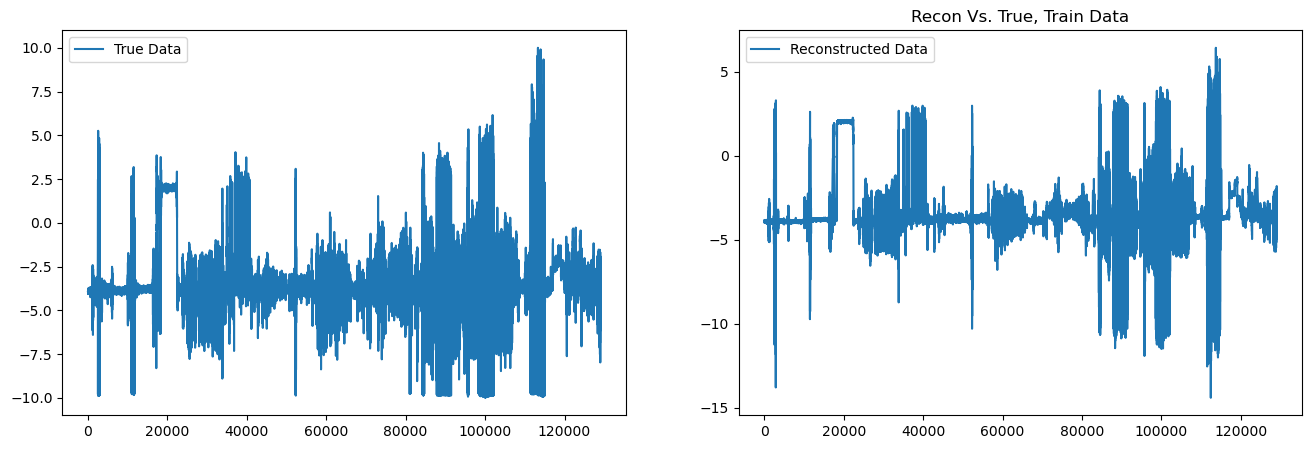

In [16]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(dataset[:split_idx], label="True Data")
plt.legend()
plt.subplot(1,2,2)
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

In [19]:
def plot_predictions(model):
    for i in range(10):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df = df['chest acceleration X-axis']
        
        df = df.to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-10, 10))

        df = scaler.fit_transform(df)
        df = pd.Series(df.squeeze())
        
        dataset = mHealth(
            dataframe=df,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Train Data")
        plt.legend()
                

C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 256x128)

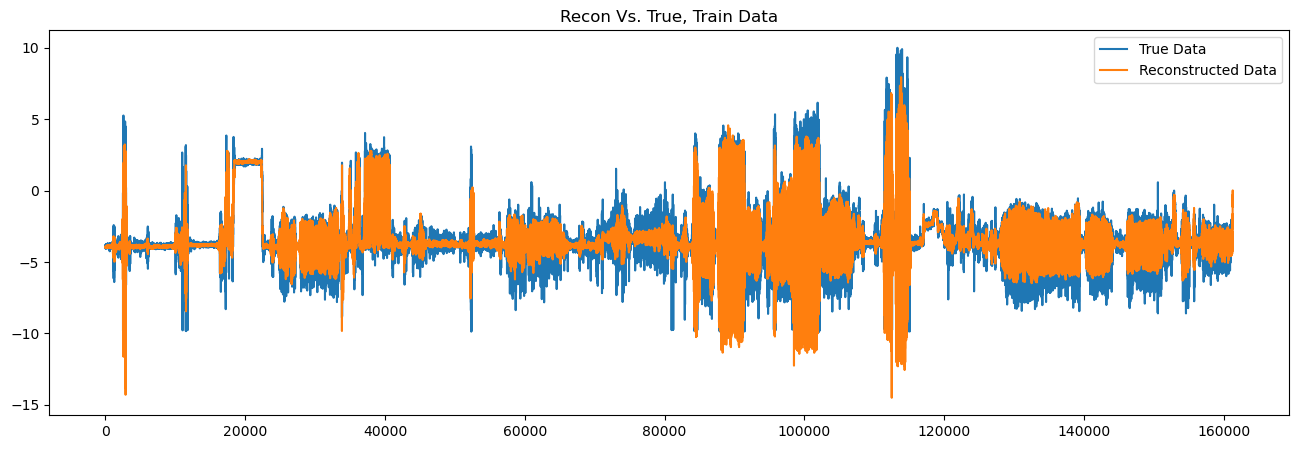

In [20]:
plot_predictions(model)

In [32]:
def plot_predictions_daphnet(model):
    
    folder_path = 'C:\\Users\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV'
    os.chdir(folder_path)
    
    for file in os.listdir():
        print(file)
        if file.endswith(".csv"):
            file_path = f"{folder_path}\\{file}"
            df = pd.read_csv(file_path)
            
            df = df['trunk acceleration lateral']
            
            df = df.to_numpy().reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(-10, 10))

            df = scaler.fit_transform(df)
            df = pd.Series(df.squeeze())
            
            dataset = mHealth(
                dataframe=df,
            )
            
            dataloader = torch.utils.data.DataLoader(
                dataset=dataset,
                batch_size=512,
                collate_fn=collate_fn,
                shuffle=False,
                drop_last=True
            )
            
            reconstructed_data = predict(model, dataloader)
            
            fig, axs = plt.subplots(3, 1, figsize=(15, 10))  # 3 rows, 1 column
            axs[0].plot(df, label="True Data")
            axs[0].plot(reconstructed_data.cpu(), label="Reconstructed Data")
            axs[0].set_title("Recon Vs. True, Daphnet")
            axs[0].legend()
            
            axs[1].plot(df, label="True Data")
            axs[1].set_title("True Daphnet")
            axs[1].legend()
            
            axs[2].plot(reconstructed_data.cpu(), label="Reconstructed Data", color='orange')
            axs[2].set_title("Recon Daphnet")
            axs[2].legend()
            
            plt.show()
            
            

    # # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S01R01.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S08R01.csv'
    

S01R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


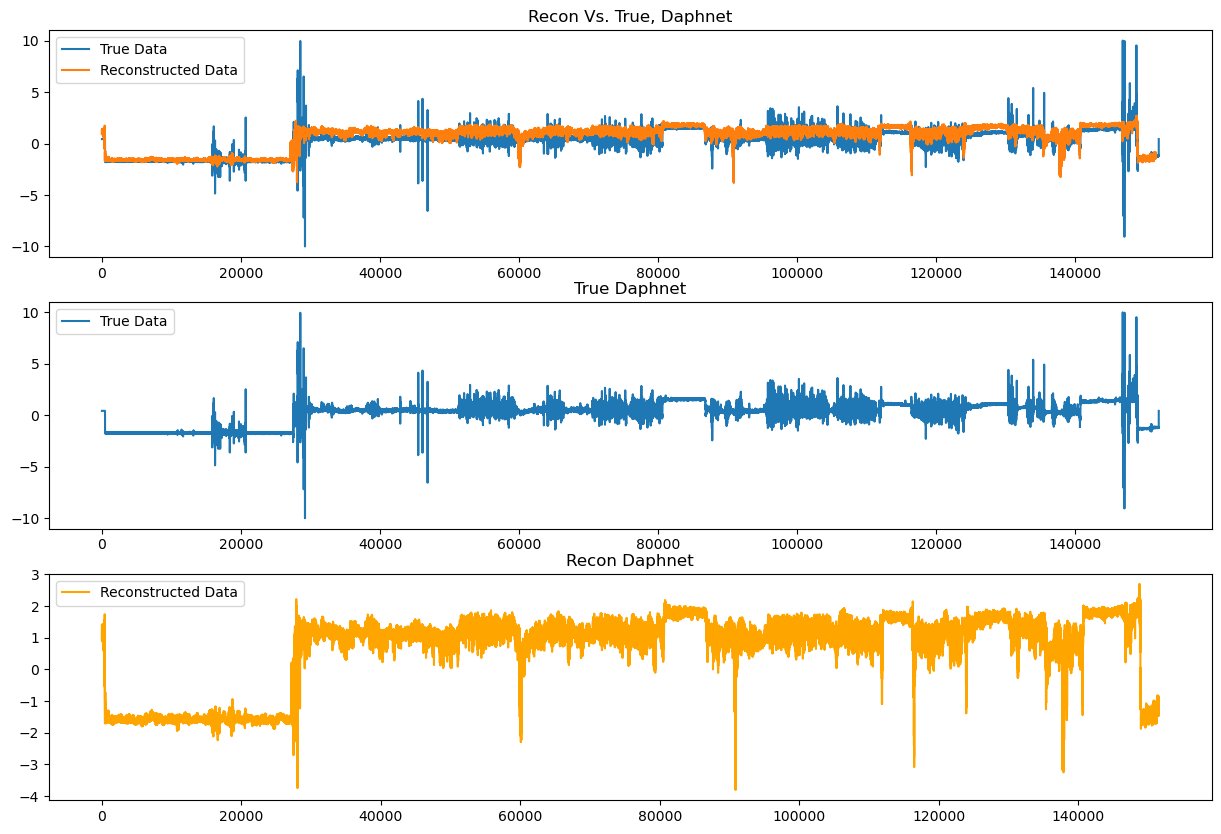

S01R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


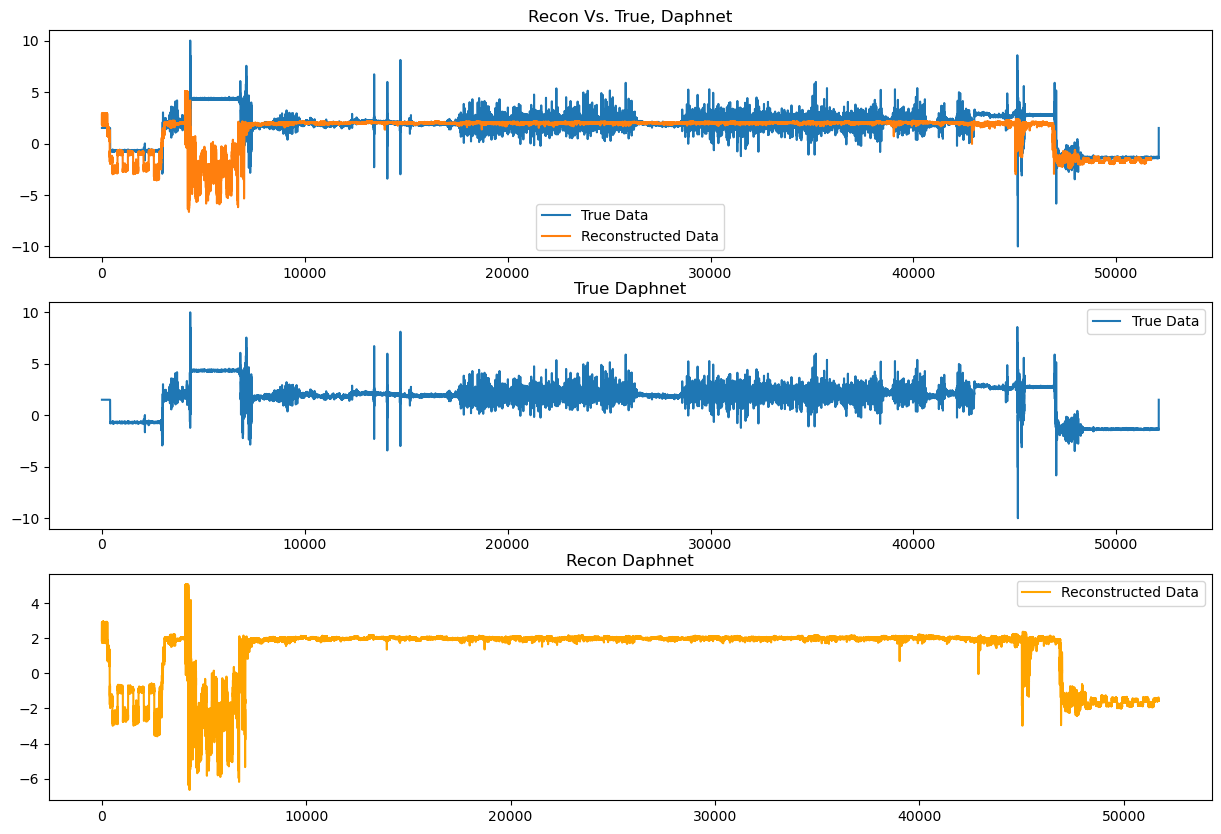

S02R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


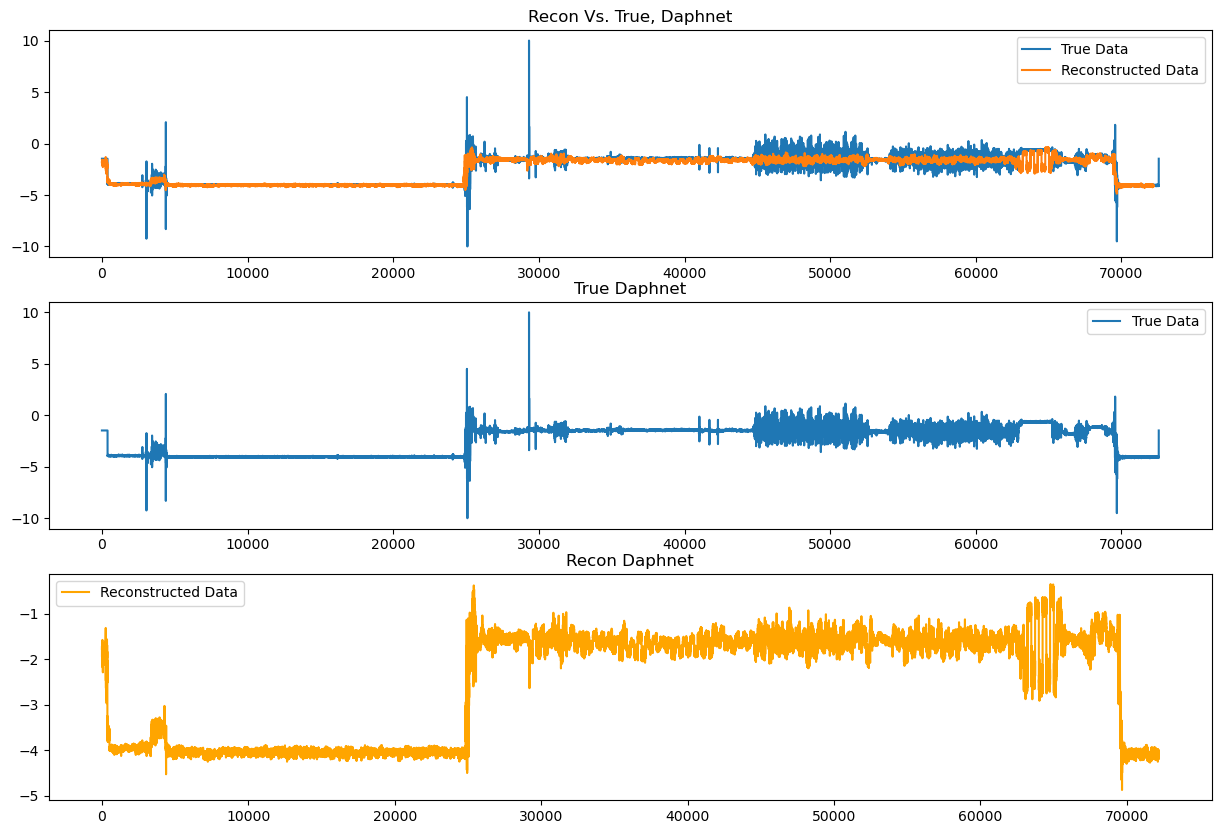

S02R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


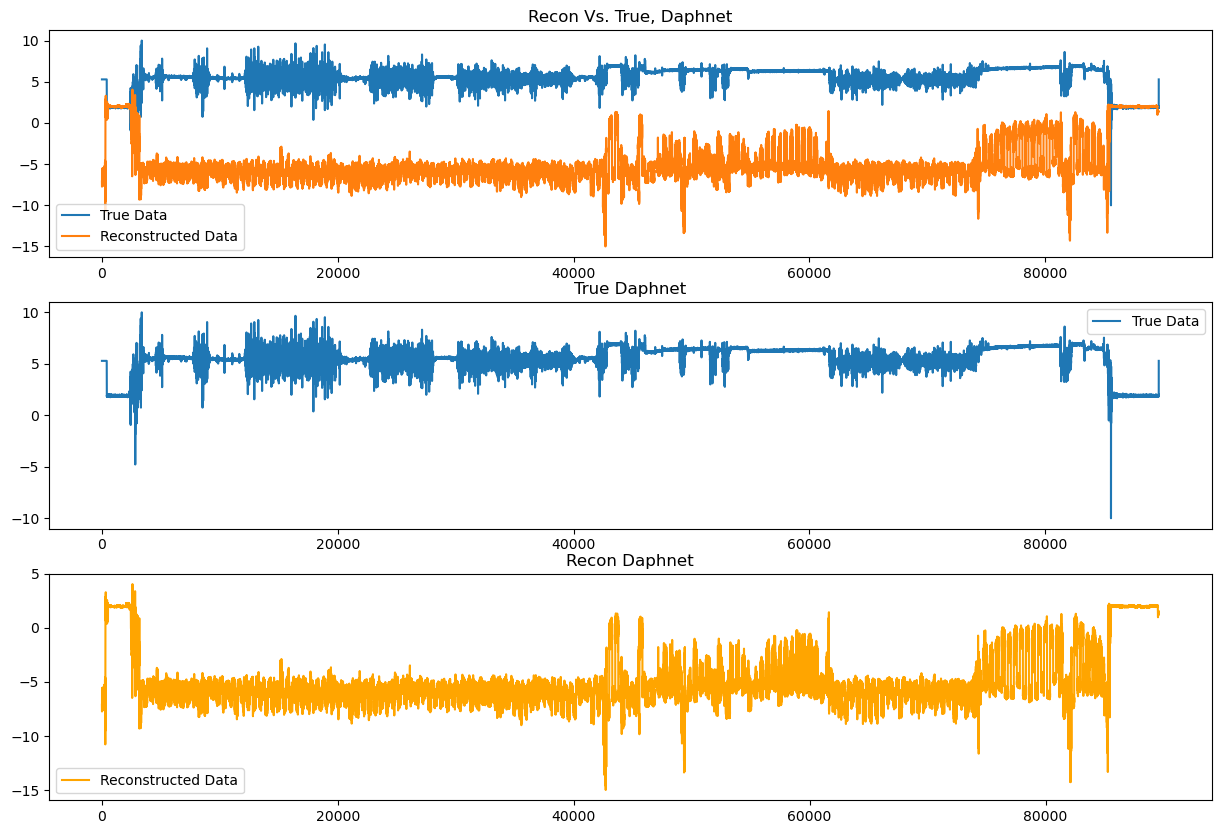

S03R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


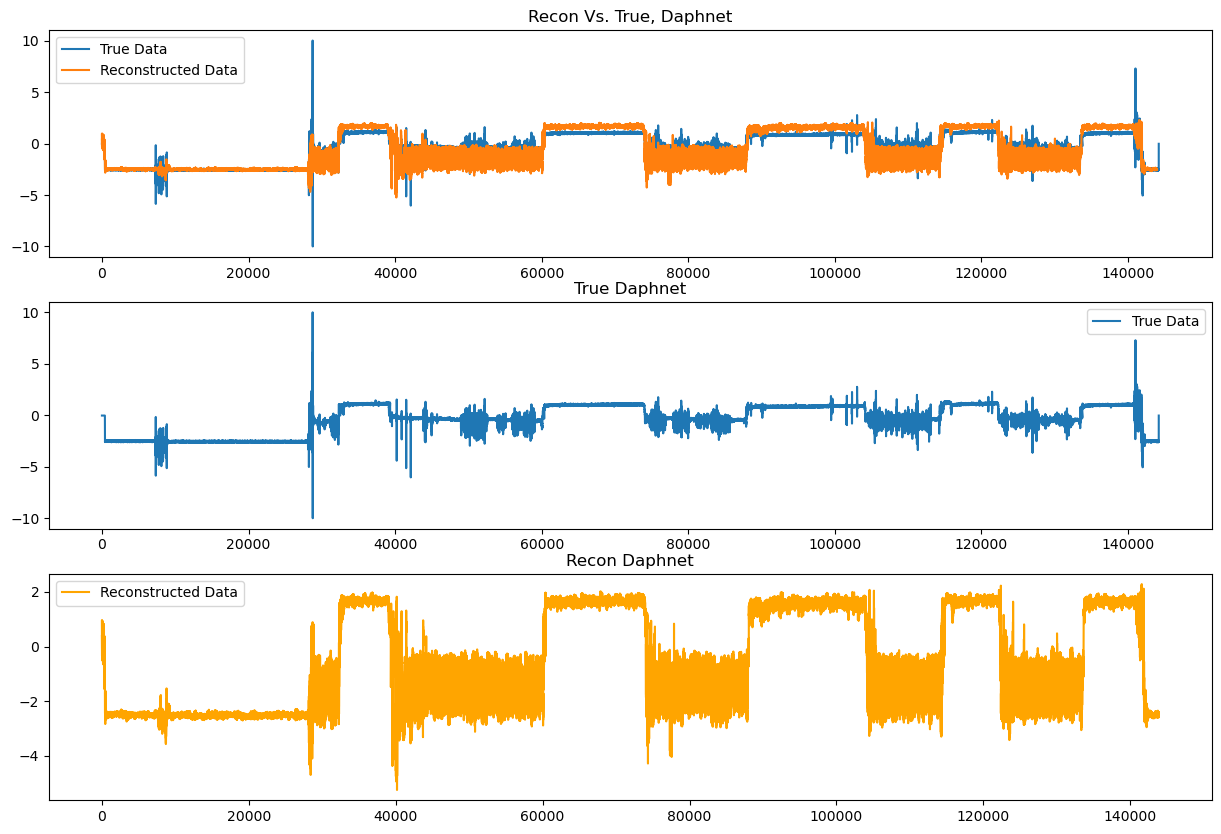

S03R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


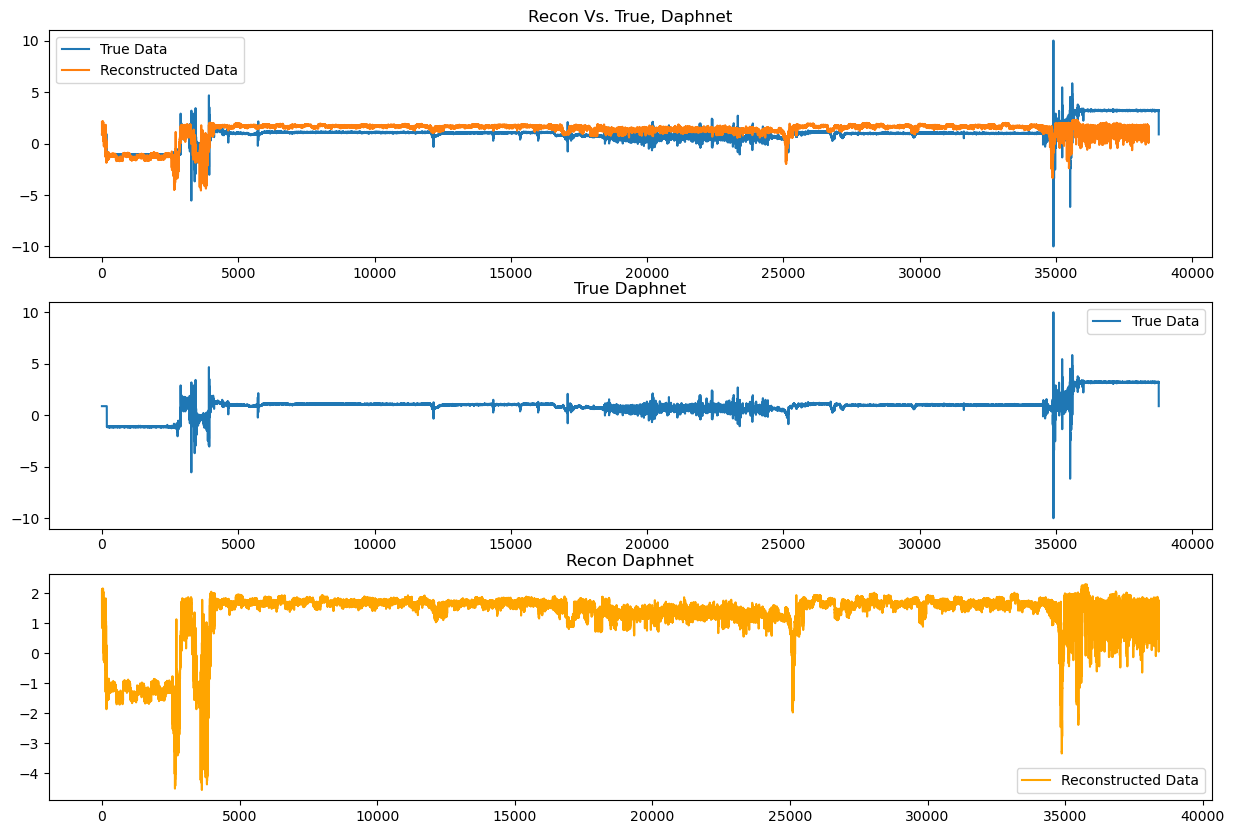

S03R03.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


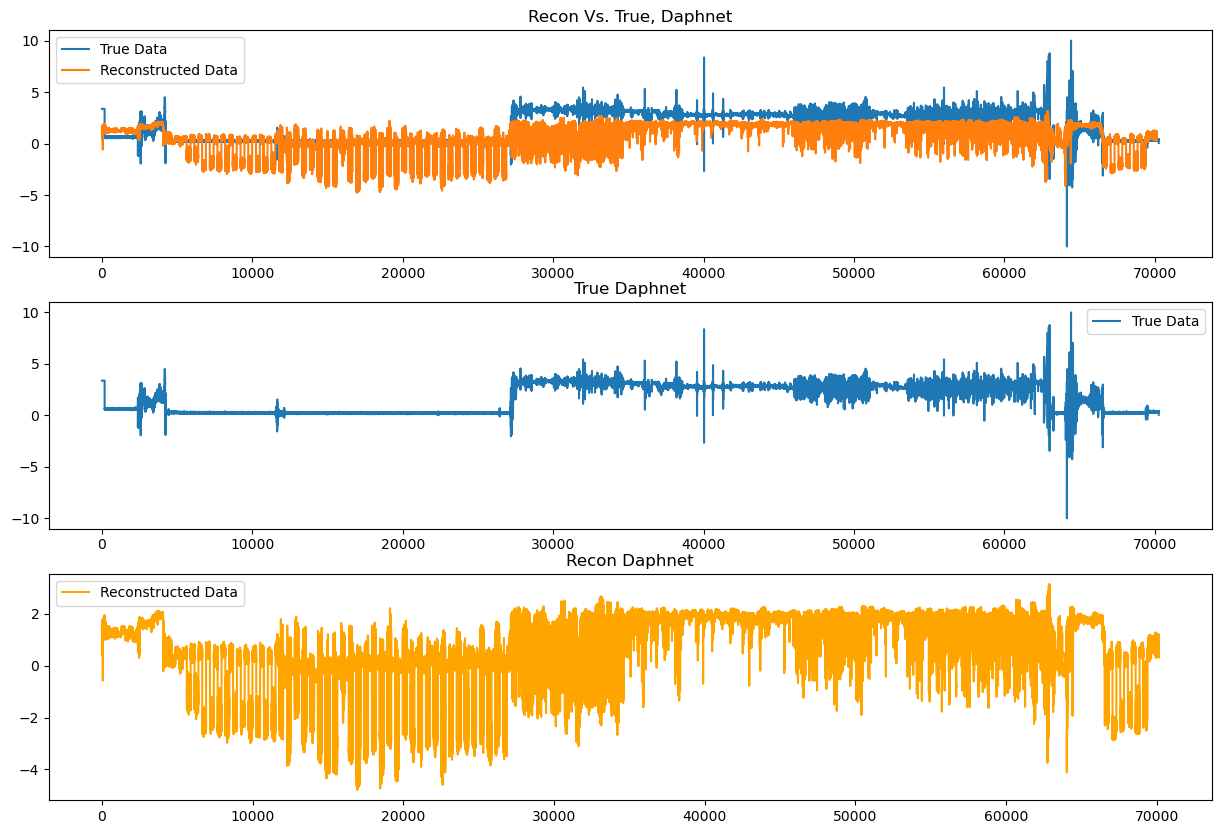

S04R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


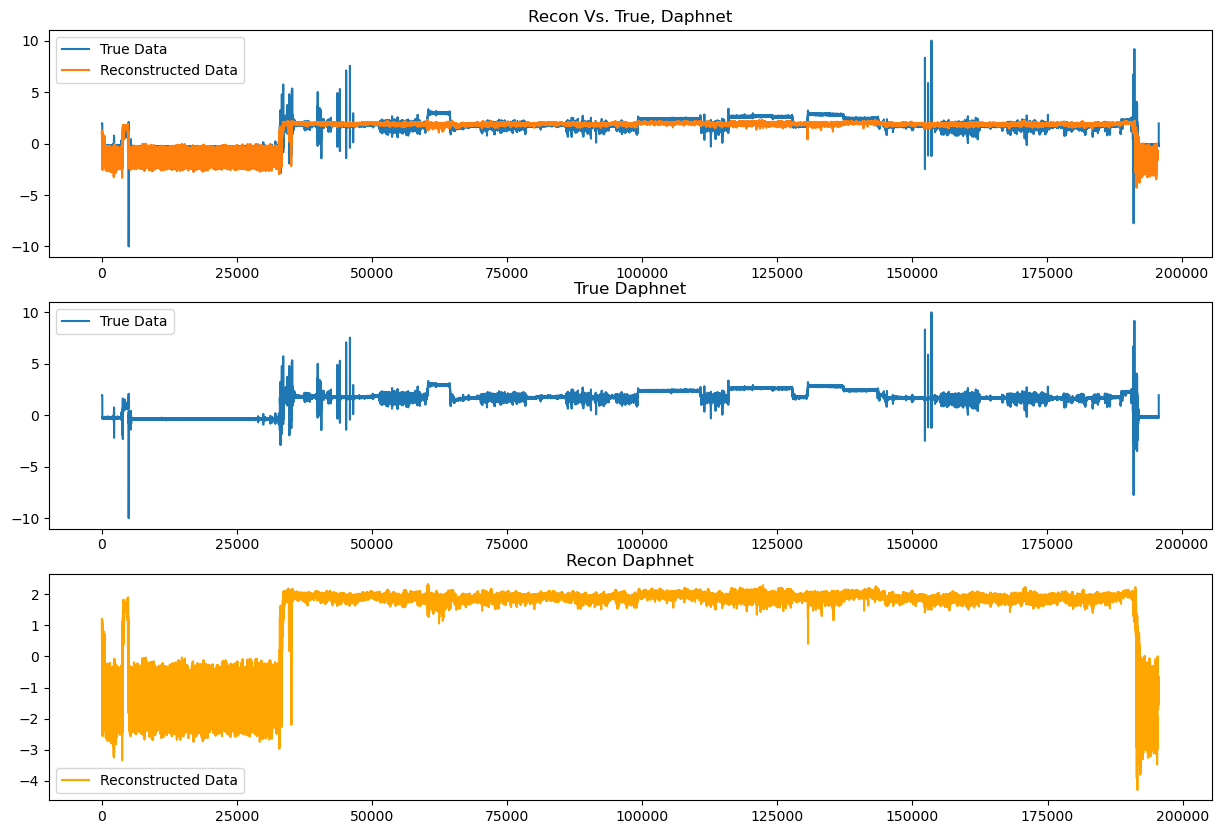

S05R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


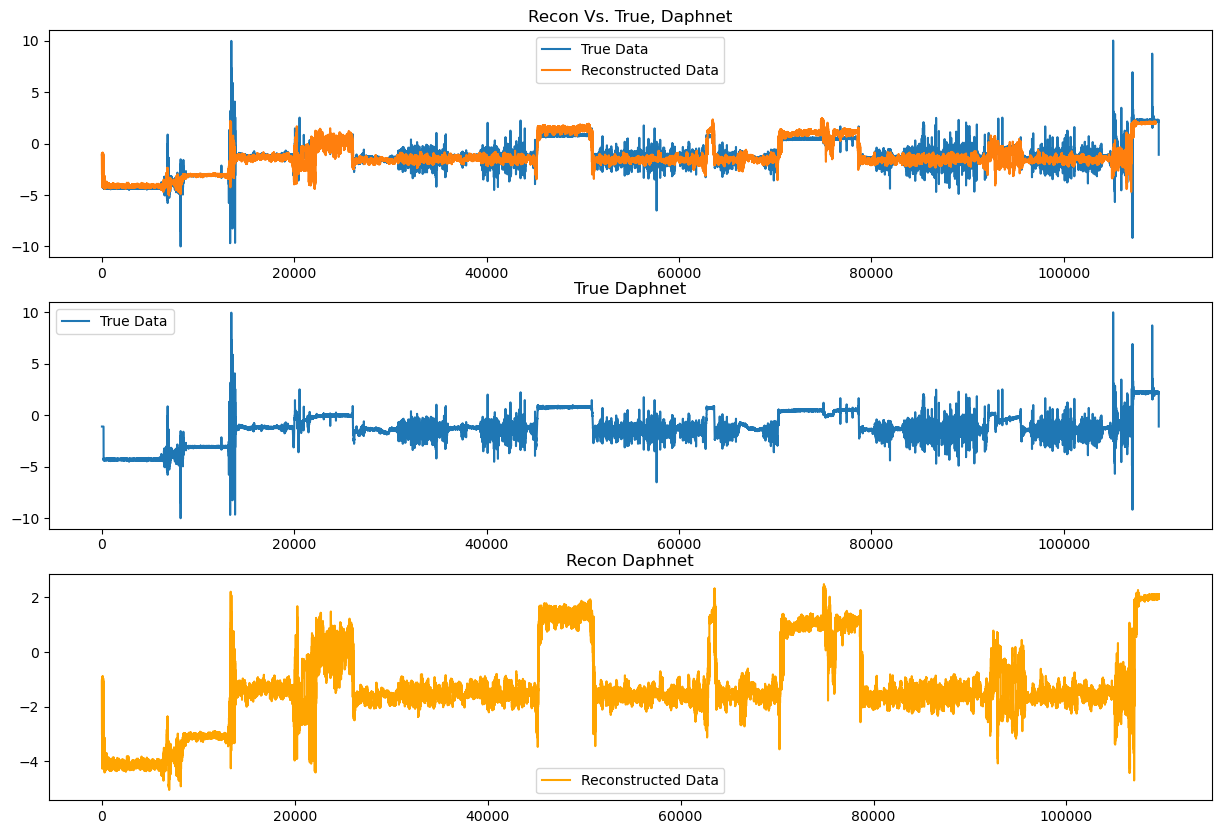

S05R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


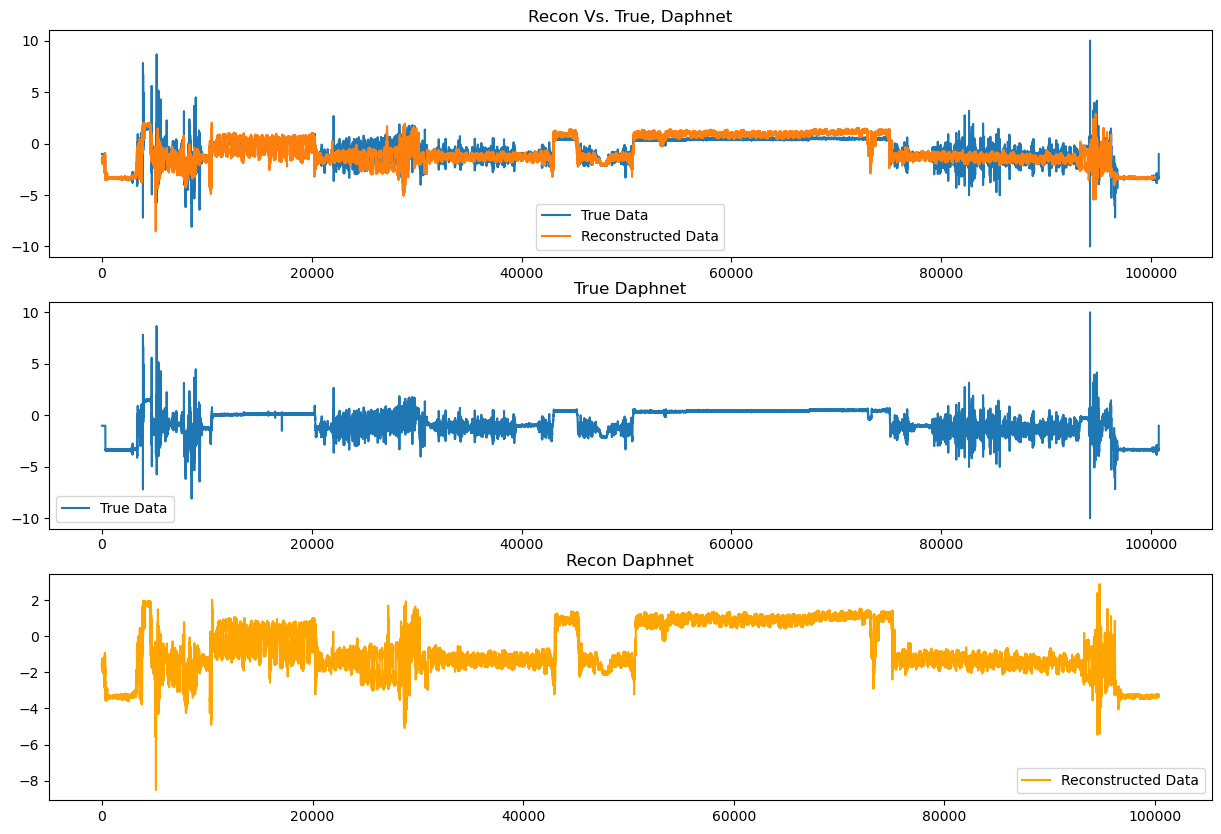

S06R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


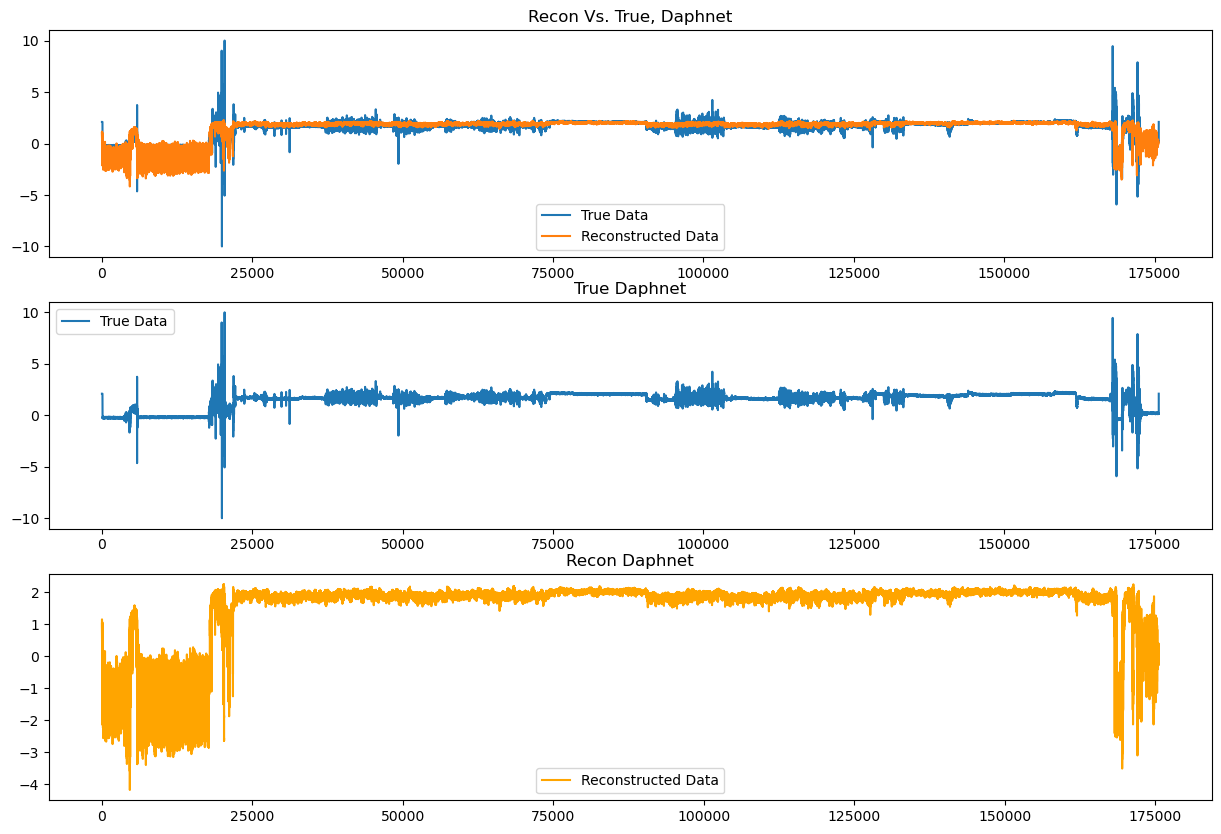

S06R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


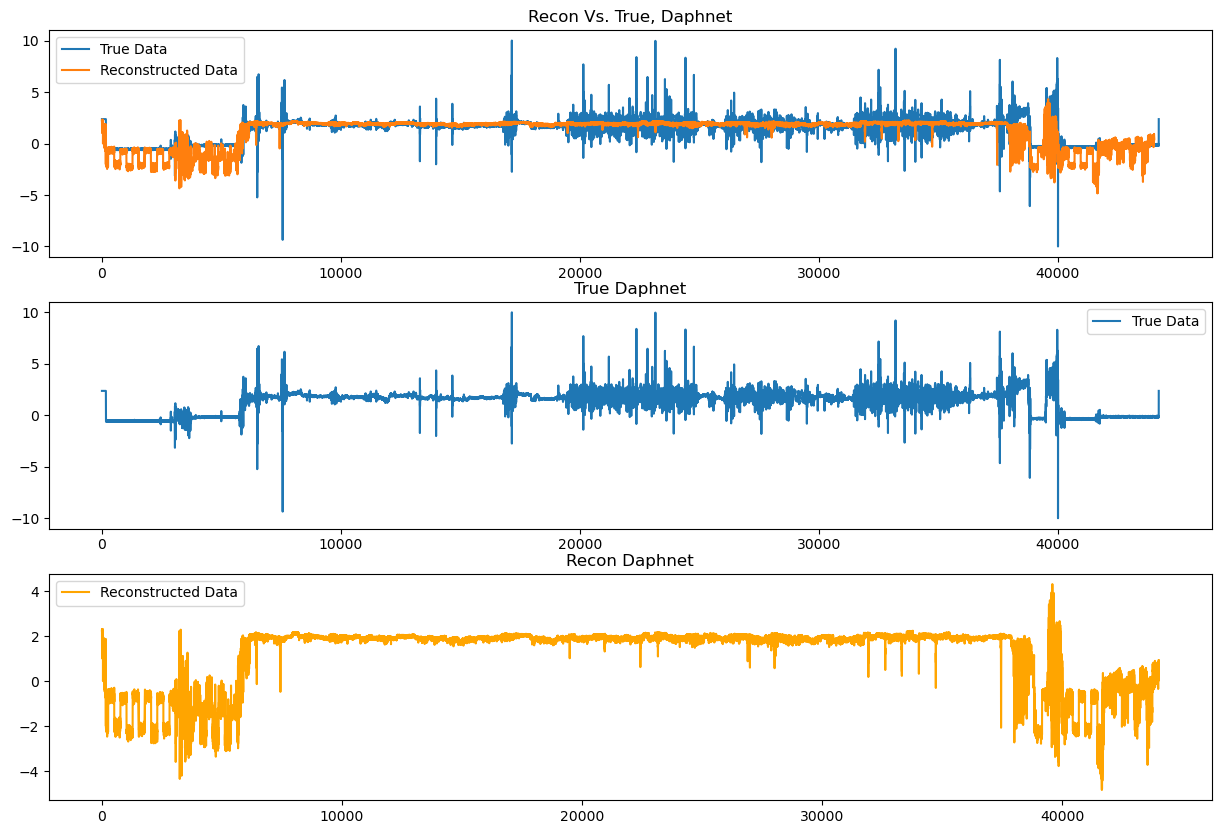

S07R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


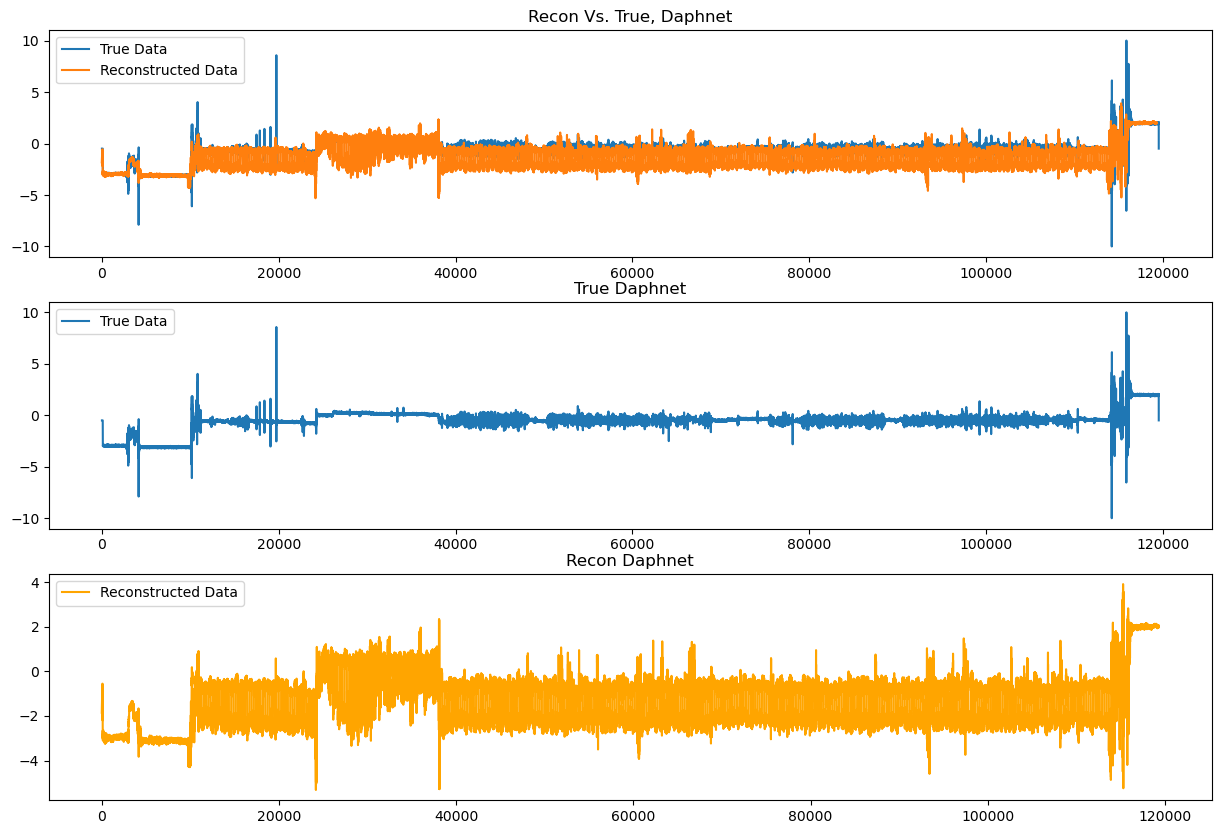

S07R02.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


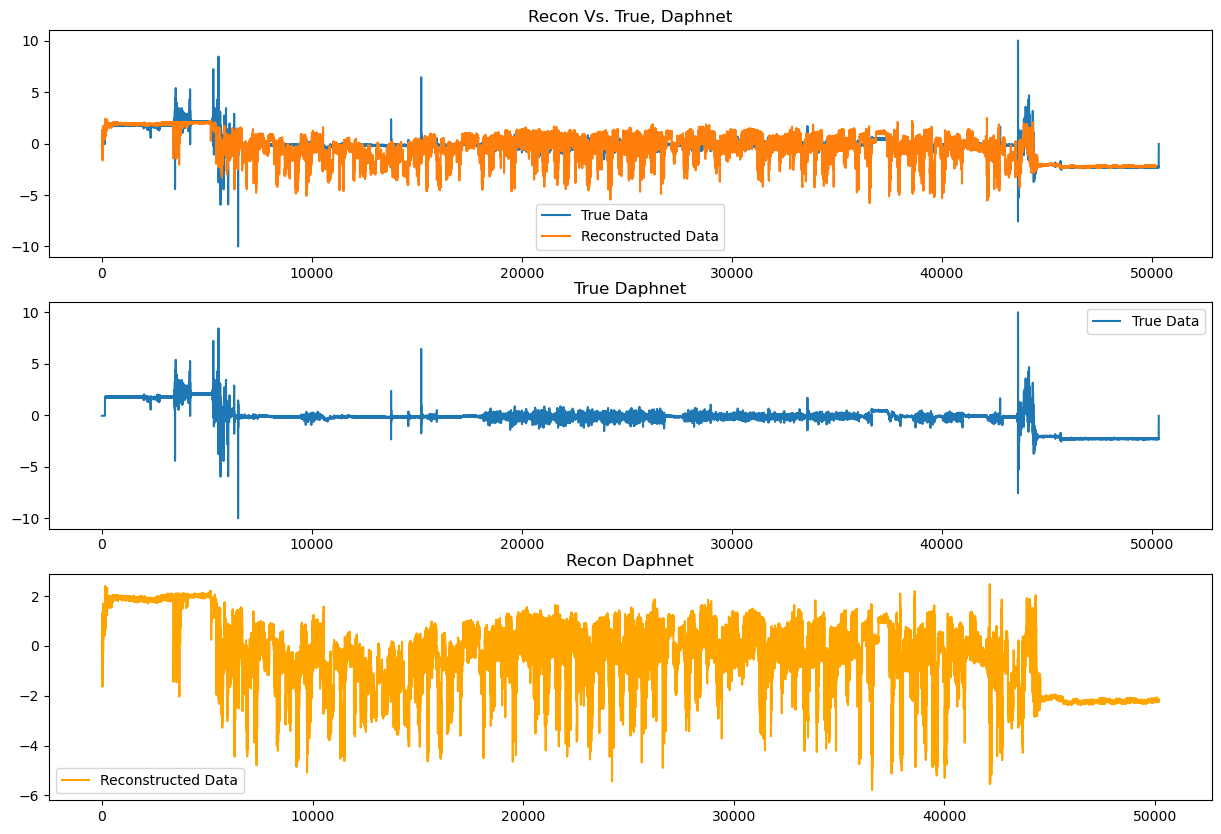

S08R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


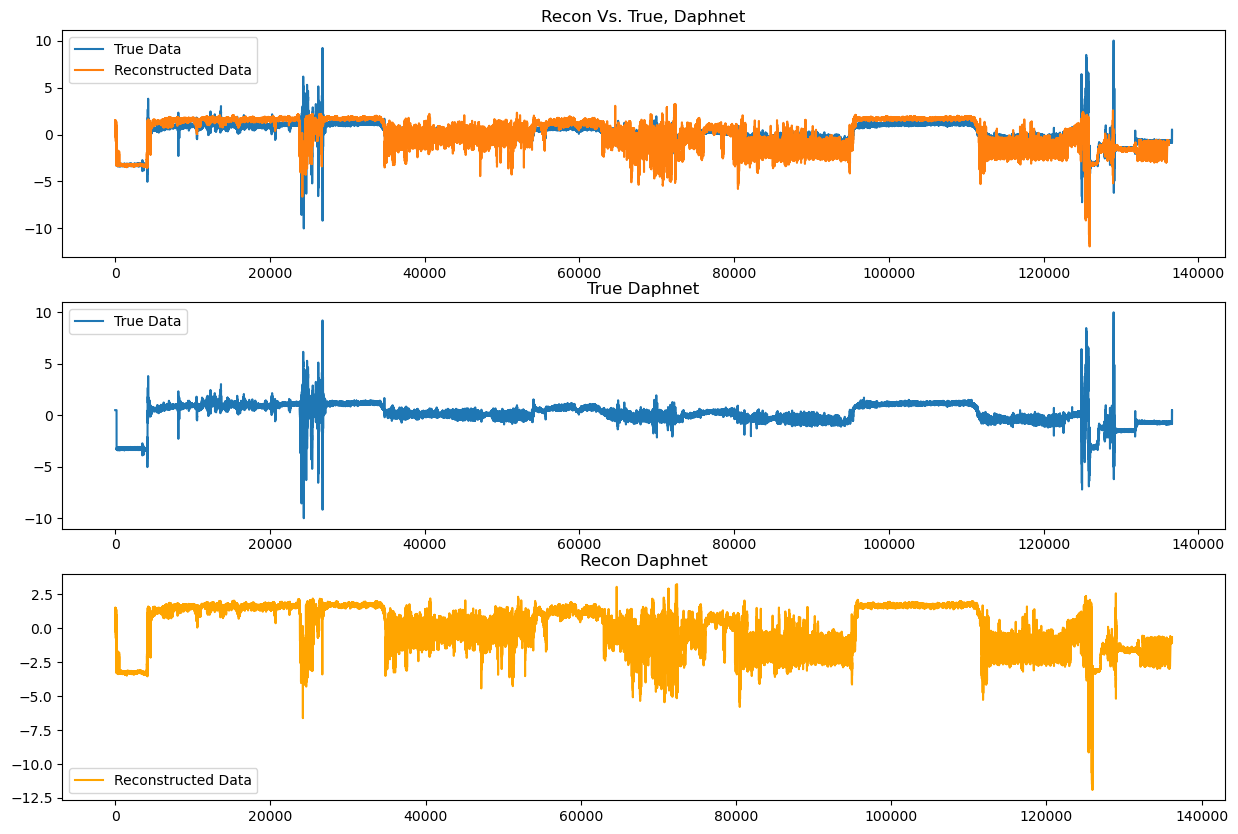

S09R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


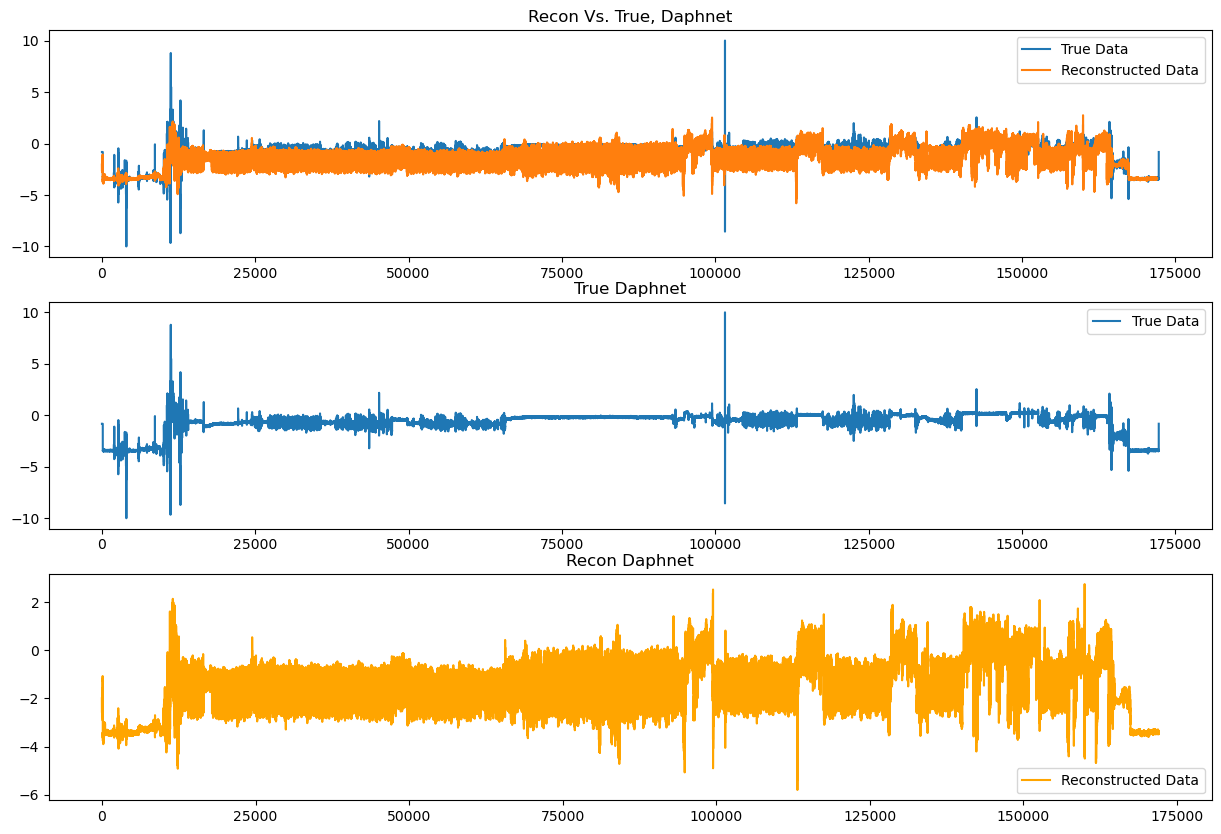

S10R01.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


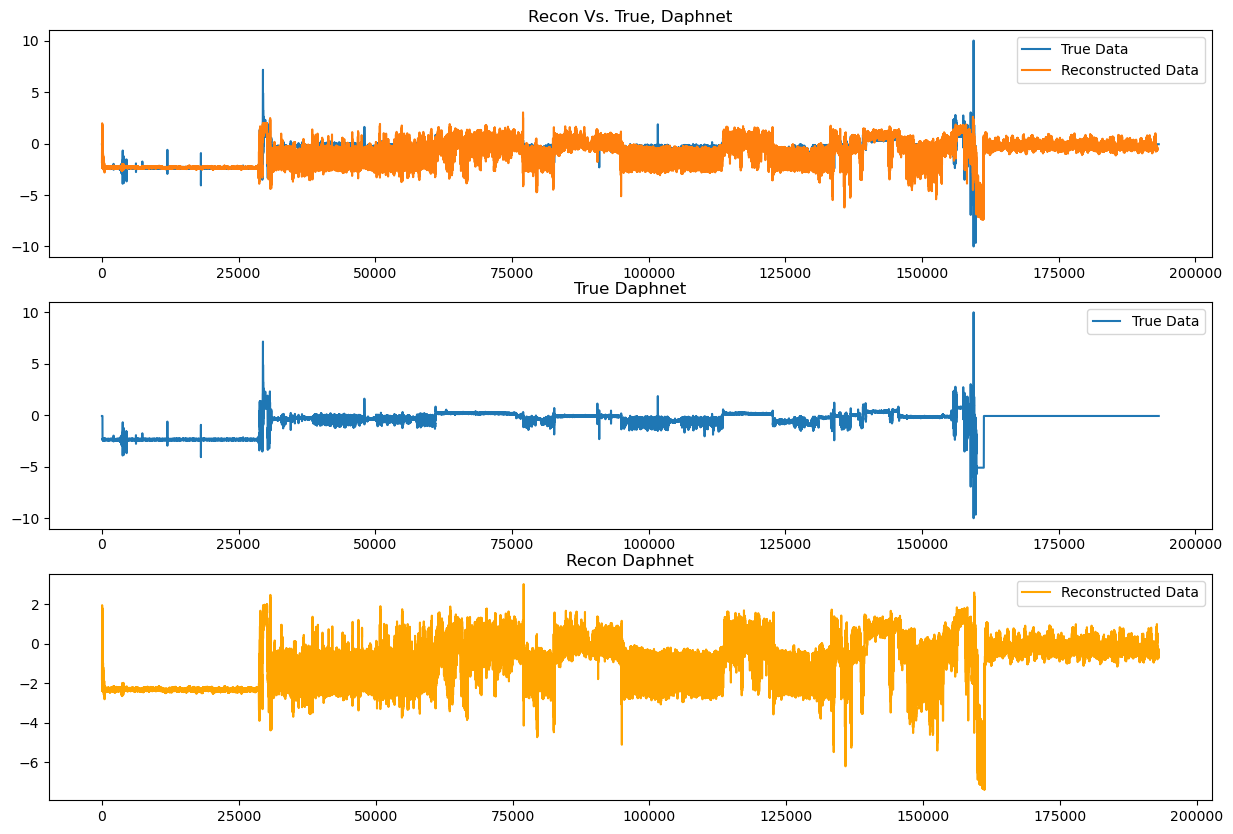

In [33]:
plot_predictions_daphnet(model)

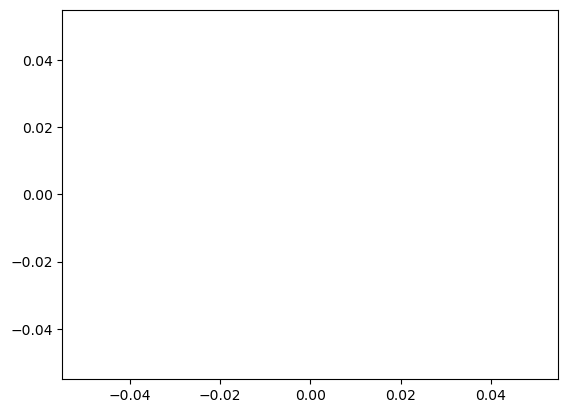

In [25]:
plt.plot(train_loss)
plt.plot(test_loss)

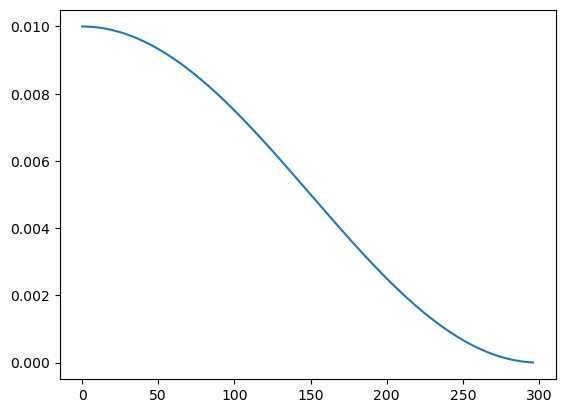

In [ ]:
plt.plot(learning_rate)

In [34]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV
file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [35]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [36]:
#splitting all mhealth data based on label, used for classification
df_null = partition_data(0, df)
df_stand = partition_data(1, df) 
df_sit = partition_data(2, df)
df_lying = partition_data(3, df)
df_walk = partition_data(4, df)
df_stairs = partition_data(5, df)
df_waist_bend = partition_data(6, df)
df_arms = partition_data(7, df) 
df_knee_bend = partition_data(8, df) 
df_cycle = partition_data(9, df) 
df_jog = partition_data(10, df) 
df_run = partition_data(11, df) 
df_jump = partition_data(12, df) 

In [51]:
class classifier_dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe['x-axis']
        # print(self.dataset)
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        # sequence = torch.tensor(self.dataset[index*128:index*128+128].to_numpy()).type(torch.float32) 
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        # print(sequence)
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        # print("seq shape: ", sequence.shape)
        label = torch.tensor(self.labels.iloc[index])
        # print("lavel shape;", label.shape)
        # print(label)
        return sequence, label

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)
    
    # print("data[0][1], ", data[0][1])

    return inputs, labels

In [52]:
split_idx = int(len(df_jump) * 0.8)

class_train = classifier_dataset(
    dataframe=df_jump[:split_idx]
)

class_test = classifier_dataset(
    dataframe=df_jump[split_idx:]
)

class_train_loader = torch.utils.data.DataLoader(
    class_train, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True,
    collate_fn=collate_fn
    )

class_test_loader = torch.utils.data.DataLoader(
    class_test, 
    batch_size=8, 
    shuffle=True, 
    drop_last=False,
    collate_fn=collate_fn
    )

class_train_loss = []
class_test_loss = []

In [65]:
class Classifier(nn.Module):

  def __init__(self, input_dim=128, num_classes=13, num_units=8, dropout=0.5, hidden=True):
    super(Classifier, self).__init__()
    self.fcin = nn.Linear(input_dim, num_units)
    self.fchidden = nn.Linear(num_units, num_units)
    self.fcout = nn.Linear(num_units, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.act = torch.nn.ReLU()
    self.h = hidden


  def forward(self, x):
    x = x.to(device)
    # print(x.device)
    x = self.act(self.fcin(x))
    if self.h:
      x = self.act(self.fchidden(x))
    x = self.dropout(x)
    x = self.fcout(x)
    return x
      
classifier = Classifier().to(device)

In [66]:
learning_rate = 0.01
num_epochs = 200
i = 0

criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(class_train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        encoded, _ = model.reconstruct(inputs.to(device))
        # print("encoded shape: ", encoded.shape)
        encoded = encoded[0, :, :]
        
        
        
        # Forward pass
        outputs = classifier(encoded.to(device)).to(device)
        
        # assert outputs.shape[0] == 13, f"Output shape mismatch: {outputs.shape}"
        # assert targets.shape[0] == 4, f"Target shape mismatch: {targets.shape}"
        
        # print(outputs.shape)
        # print(targets.shape)
        # print(type(targets))
       
        y_pred = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
        
        running_train_loss += loss.item() * inputs.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_test_loss = 0.0
    
    epoch_train_loss = running_train_loss / len(class_train_loader)
    class_train_loss.append(float(epoch_train_loss))

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            
            encoded, _ = model.reconstruct(inputs)
            encoded = encoded[0, :, :]
            outputs = classifier(encoded).to(device)
            
            loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
            running_test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted.to(device) == targets.to(device)).sum().item()
    
    epoch_test_loss = running_test_loss / len(class_test_loader)
    class_test_loss.append(epoch_test_loss)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\4178157600.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\4178157600.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Epoch [1/200], Loss: 1.5713
Epoch [2/200], Loss: 1.7873
Epoch [3/200], Loss: 1.3548
Epoch [4/200], Loss: 1.7873
Epoch [5/200], Loss: 1.5711
Epoch [6/200], Loss: 1.3548
Epoch [7/200], Loss: 1.7873
Epoch [8/200], Loss: 1.3548
Epoch [9/200], Loss: 2.0036
Epoch [10/200], Loss: 1.5711
Epoch [11/200], Loss: 1.1386
Epoch [12/200], Loss: 1.7873
Epoch [13/200], Loss: 1.7873
Epoch [14/200], Loss: 1.5711
Epoch [15/200], Loss: 1.7873
Epoch [16/200], Loss: 2.0036
Epoch [17/200], Loss: 2.0036
Epoch [18/200], Loss: 1.7873
Epoch [19/200], Loss: 2.0036
Epoch [20/200], Loss: 1.7873
Epoch [21/200], Loss: 1.5711
Epoch [22/200], Loss: 1.1386
Epoch [23/200], Loss: 1.3548
Epoch [24/200], Loss: 1.3548
Epoch [25/200], Loss: 1.5711
Epoch [26/200], Loss: 1.3548
Epoch [27/200], Loss: 1.5711
Epoch [28/200], Loss: 1.3548
Epoch [29/200], Loss: 1.1386
Epoch [30/200], Loss: 1.3548
Epoch [31/200], Loss: 1.7873
Epoch [32/200], Loss: 1.7873
Epoch [33/200], Loss: 1.1386
Epoch [34/200], Loss: 1.5711
Epoch [35/200], Loss: 1

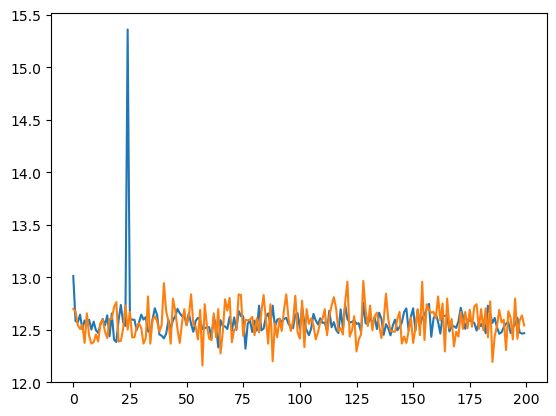

In [67]:
plt.plot(class_train_loss)
plt.plot(class_test_loss)

In [ ]:
# df_null = partition_data(0, df)
# df_stand = partition_data(1, df) 
# df_sit = partition_data(2, df)
# df_lying = partition_data(3, df)
# df_walk = partition_data(4, df)
# df_stairs = partition_data(5, df)
# df_waist_bend = partition_data(6, df)
# df_arms = partition_data(7, df) 
# df_knee_bend = partition_data(8, df) 
# df_cycle = partition_data(9, df) 
# df_jog = partition_data(10, df) 
# df_run = partition_data(11, df) 
# df_jump = partition_data(12, df) 

In [100]:
# df_null.to_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTH_PARTITIONED_CSV\\df_null.csv', index=False)

In [102]:
df_arms

,x-axis,y-axis,z-axis,label
0,-9.3187,0.78520,2.0601,7.0
1,-10.3470,0.65888,1.5435,7.0
2,-10.3320,0.45855,1.3886,7.0
3,-9.9735,0.69687,2.1575,7.0
4,-9.7907,0.64792,2.1846,7.0
...,...,...,...,...
29436,-9.2102,-2.11760,1.5357,7.0
29437,-9.5888,-1.87200,1.8526,7.0
29438,-9.8425,-2.31800,1.7598,7.0
29439,-9.3843,-2.50150,1.3749,7.0


In [107]:
X_train, X_test, y_train, y_test = [], [], [], []

# for batch_idx, (inputs, targets) in enumerate(class_train_loader):
#     encoded, _ = model.reconstruct(inputs.to(device))
#     # print("encoded shape: ", encoded.shape)
#     encoded = encoded[0, 0, :]
#     # print(encoded.shape)
    
#     X_train.append(encoded.cpu().detach().numpy())
#     y_train.append(targets.cpu().detach().numpy())
    
#     # print(type(encoded.cpu().detach().numpy()))
    
# for batch_idx, (inputs, targets) in enumerate(class_test_loader):
#     encoded, _ = model.reconstruct(inputs.to(device))
#     # print("encoded shape: ", encoded.shape)
#     encoded = encoded[0, 0, :]
    
#     X_test.append(encoded.cpu().detach().numpy())
#     y_test.append(targets.cpu().detach().numpy())
    
    
X, y = [], []

partitioned_path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\dataset\\MHEALTH_PARTITIONED_CSV'

os.chdir(partitioned_path)

for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}\\{file}"
        
        print("Current file: ", file_path)
        
        temp = pd.read_csv(file_path)
        x_data = temp['x-axis'].to_numpy()
        y_data = temp['label'].to_numpy()
        
        split_idx = int(len(x_data) * 0.8)

        class_train = classifier_dataset(
            dataframe=x_data[:split_idx]
        )

        class_test = classifier_dataset(
            dataframe=x_data[split_idx:]
        )

        class_train_loader = torch.utils.data.DataLoader(
            class_train, 
            batch_size=8, 
            shuffle=True, 
            drop_last=True,
            collate_fn=collate_fn
            )

        class_test_loader = torch.utils.data.DataLoader(
            class_test, 
            batch_size=8, 
            shuffle=True, 
            drop_last=False,
            collate_fn=collate_fn
            )

        for batch_idx, (inputs, targets) in enumerate(class_train_loader):
            encoded, _ = model.reconstruct(inputs.to(device))
            # print("encoded shape: ", encoded.shape)
            encoded = encoded[0, 0, :]
            # print(encoded.shape)
            
            X_train.append(encoded.cpu().detach().numpy())
            y_train.append(targets.cpu().detach().numpy())
            
        # print(type(encoded.cpu().detach().numpy()))
        
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            encoded, _ = model.reconstruct(inputs.to(device))
            # print("encoded shape: ", encoded.shape)
            encoded = encoded[0, 0, :]
            
            X_test.append(encoded.cpu().detach().numpy())
            y_test.append(targets.cpu().detach().numpy())
            
            encoded, _ = model.reconstruct(inputs.to(device))
            encoded = encoded[0, 0, :]
            
            # X.append(x_data)
            # y.append(y_data)
            

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\dataset\\MHEALTH_PARTITIONED_CSV'

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification



# Split the dataset into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
print(type(X_train))
# Training loop
classifier.fit(np.array(X_train), np.array(y_train))
print(type(X_train))
# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\4178157600.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_2340\4178157600.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


<class 'list'>
<class 'list'>
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00       258
           2       1.00      1.00      1.00       258
           3       1.00      1.00      1.00       258
           4       1.00      1.00      1.00       258
           5       1.00      1.00      1.00       258
           6       1.00      1.00      1.00       258
           7       1.00      1.00      1.00       258

   micro avg       1.00      1.00      1.00      2064
   macro avg       1.00      1.00      1.00      2064
weighted avg       1.00      1.00      1.00      2064
 samples avg       1.00      1.00      1.00      2064



In [38]:
encoded = Encoder(df_jump['x-axis'][:128])

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got Series"

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Net,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss()

)